# Prediction of time series with different neural networks architectures

In this notebook we will use different network architectures to predict the next steps for a time series. We compare: 

* 1D causal convolutional networks 
* 1D causal convolutional networks witho dilation rate
* RNNs  
* LSTMs

We forecast a time series for longer times than we trained them on and compare the results of the different architectures. The goal is to capture the longterm dependencies of the time series.


In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D,LSTM, SimpleRNN


## Simulate some data

We produce training data with two different time scales and a bit of noise. This produces 1000 curves which all follow the same pattern: a fast changing sine wave where the amplitude is modulated by a sine wave with lower frequency. To make it a bit more challenging, we add some noise at each timestep of the waves. All of the 1000 waves have the same pattern, however, the starting point is randomly shifted in time. One such example is shown the plot below. The first 128 data points are used as an input to the model (shown as a line). The model should predict the following 10 data points (shown as points). Note that the future data does not follow a smooth curve, but instead is ragged because of the random noise present in the data.

C:\Users\malte\AppData\Local\Temp\ipykernel_16092\3609720393.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')
C:\Users\malte\AppData\Local\Temp\ipykernel_16092\3609720393.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')


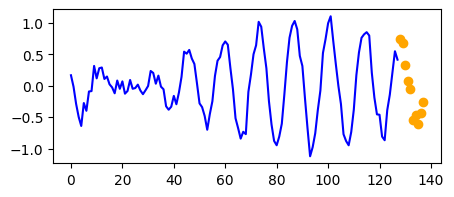

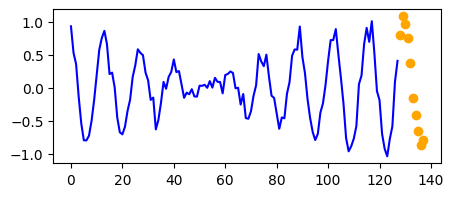

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [3]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(2):
  plt.figure(num=None, figsize=(5,2))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

### Build network
Here we define a Neural network with 1D convolutions and "causal" padding. 

Build a first model using the causal convolutions. Don't specify the sequence length (batch_input_shape=(None, None, 1)), so you can use a different sequence length in prediction later. The network should have 4, 1-dimensional convolutional layers, with a kernelsize of `ks=5` and 32 feartures. Use the keras function `Convolution1D` for that. The network should report 10 values that the end. You can achive this with the function.

```{pyhon}
def slice(x, slice_length):
    return x[:,-slice_length:,:]
...
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
```

Which you add at the end of the network.

Use the first 800 sequences for training and the last 200 for validation. As loss function we use the mean squared error (MSE). You should get a MSE of approx 0.02 to 0.03.

In [4]:
model = Sequential()
model.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=1, use_bias=True, batch_input_shape=(None, None, 1)))
model.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=1, use_bias=True))
model.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=1, use_bias=True))
model.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=1, use_bias=True))
model.add(Dense(1))
def slice(x, slice_length):
    return x[:,-slice_length:,:]
model.add(Lambda(slice, arguments={'slice_length':look_ahead}))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_3 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense (Dense)               (None, None, 1)           33        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-traina

In [5]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X[0:800], Y[0:800], epochs=20, batch_size=128, validation_data=(X[800:1000], Y[800:1000]))

Epoch 1/20
7/7 [==============================] - 2s 96ms/step - loss: 0.1326 - val_loss: 0.0754
Epoch 2/20
7/7 [==============================] - 0s 48ms/step - loss: 0.0506 - val_loss: 0.0520
Epoch 3/20
7/7 [==============================] - 0s 57ms/step - loss: 0.0480 - val_loss: 0.0358
Epoch 4/20
7/7 [==============================] - 0s 55ms/step - loss: 0.0411 - val_loss: 0.0344
Epoch 5/20
7/7 [==============================] - 0s 54ms/step - loss: 0.0362 - val_loss: 0.0332
Epoch 6/20
7/7 [==============================] - 0s 54ms/step - loss: 0.0352 - val_loss: 0.0318
Epoch 7/20
7/7 [==============================] - 0s 55ms/step - loss: 0.0327 - val_loss: 0.0288
Epoch 8/20
7/7 [==============================] - 0s 54ms/step - loss: 0.0315 - val_loss: 0.0278
Epoch 9/20
7/7 [==============================] - 0s 56ms/step - loss: 0.0299 - val_loss: 0.0261
Epoch 10/20
7/7 [==============================] - 0s 58ms/step - loss: 0.0288 - val_loss: 0.0257
Epoch 11/20
7/7 [============

In [6]:
#YOUR_CODE_HERE

### Make repeated predictions



Since we work with simulated data, we can produce as much new data as we like. We can also switch off the noise and check how well the model can extract the real underlying pattern in the data.

In [7]:
x_test,y_test = gen_data(size=1,noise=0.0)
print(x_test.shape)
print(y_test.shape)
model.predict(x_test).reshape(-1)#Predicts 10 value

(1, 128, 1)
(1, 10, 1)
1/1 [==============================] - 0s 174ms/step


array([ 0.8880685 ,  0.8175476 ,  0.5885901 ,  0.25200924, -0.1202514 ,
       -0.45061907, -0.6722105 , -0.7425013 , -0.6515251 , -0.42301738],
      dtype=float32)

Write a function which predicts 10 values from a starting sequence of size 128. Then add these predicted values to the starting sequence and uses this sequence of length 138 as a new starting sequence. Repeat this procedure 12 times. You should get a prediction for 120 time points in the future.  

In [8]:
# Your code here
x_test, y_test = gen_data(size=1, noise=0.0)
y = []
def predict_sequence(model, sequence, repeat=12):
    for i in range(12):
        pred = model.predict(sequence)
        sequence = np.concatenate((sequence, pred.reshape((1, 10, 1))), axis=1)
    return sequence.reshape(sequence.shape[1])[-repeat*10:]

In [9]:
x = x_test.copy()
pred = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).reshape((1, 10, 1))
np.concatenate((x, pred), axis=1).shape
pred.shape




(1, 10, 1)

In [10]:
pred = predict_sequence(model, x_test, 12)

1/1 [==============================] - 0s 27ms/step


C:\Users\malte\AppData\Local\Temp\ipykernel_16092\733296194.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')


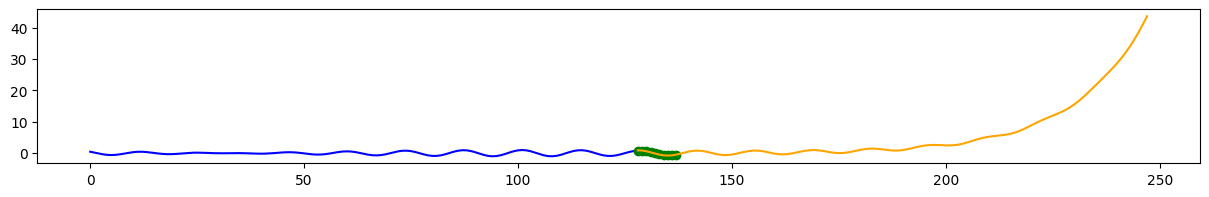

In [11]:
plt.figure(num=None, figsize=(15,2))  
plt.plot(range(0, seq_length),x_test[0,:,0],'b-')
plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')
plt.plot(range(seq_length, seq_length + 120),pred,color='orange')

plt.show()

## B) 1D Convolution with dilation rate


Here we define a Neural network with 1D convolutions and "causal" padding, this time with dilation rate, so we are able to look back longer in time (see figure below)
 
![](https://i.stack.imgur.com/20xRe.png)

Build the same network as in A) but this time with dilation_rates 1,2,4,8 

In [12]:
modeldil = Sequential()
modeldil.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=1, use_bias=True, batch_input_shape=(None, None, 1)))
modeldil.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=2, use_bias=True))
modeldil.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=4, use_bias=True))
modeldil.add(Convolution1D(filters=32, kernel_size=5, padding='causal', dilation_rate=8, use_bias=True))
modeldil.add(Dense(1))
def slice(x, slice_length):
    return x[:,-slice_length:,:]
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modeldil.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          192       
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 conv1d_7 (Conv1D)           (None, None, 32)          5152      
                                                                 
 dense_1 (Dense)             (None, None, 1)           33        
                                                                 
 lambda_1 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 15,681
Trainable params: 15,681
Non-trai

In [13]:
modeldil.compile(optimizer='adam', loss='mean_squared_error')
history = modeldil.fit(X[0:800], Y[0:800], epochs=20, batch_size=128, validation_data=(X[800:1000], Y[800:1000]))

Epoch 1/20
7/7 [==============================] - 2s 109ms/step - loss: 0.1334 - val_loss: 0.0564
Epoch 2/20
7/7 [==============================] - 1s 76ms/step - loss: 0.0424 - val_loss: 0.0237
Epoch 3/20
7/7 [==============================] - 0s 69ms/step - loss: 0.0211 - val_loss: 0.0192
Epoch 4/20
7/7 [==============================] - 1s 76ms/step - loss: 0.0181 - val_loss: 0.0151
Epoch 5/20
7/7 [==============================] - 0s 70ms/step - loss: 0.0154 - val_loss: 0.0145
Epoch 6/20
7/7 [==============================] - 1s 76ms/step - loss: 0.0141 - val_loss: 0.0125
Epoch 7/20
7/7 [==============================] - 0s 72ms/step - loss: 0.0133 - val_loss: 0.0126
Epoch 8/20
7/7 [==============================] - 1s 75ms/step - loss: 0.0133 - val_loss: 0.0123
Epoch 9/20
7/7 [==============================] - 1s 77ms/step - loss: 0.0130 - val_loss: 0.0121
Epoch 10/20
7/7 [==============================] - 1s 73ms/step - loss: 0.0129 - val_loss: 0.0122
Epoch 11/20
7/7 [===========

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [14]:
#x_test, y_test = gen_data(size=1, noise=0.0)

preddil = predict_sequence(modeldil, x_test, 12)

1/1 [==============================] - 0s 59ms/step


C:\Users\malte\AppData\Local\Temp\ipykernel_16092\2253883042.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')


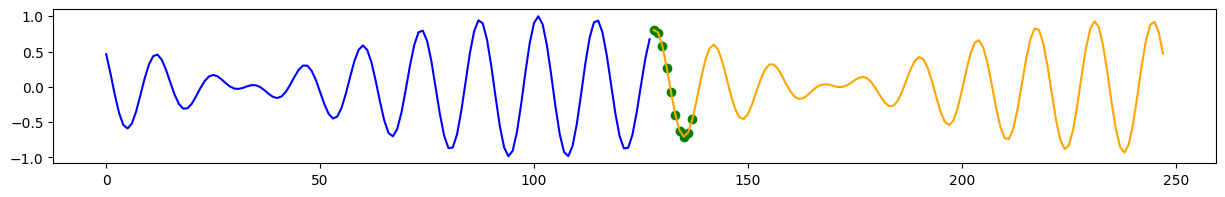

In [15]:
plt.figure(num=None, figsize=(15,2))  
plt.plot(range(0, seq_length),x_test[0,:,0],'b-')
plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')
plt.plot(range(seq_length, seq_length + 120),preddil,color='orange')

plt.show()

## C) Simple RNN

Now, use a RNN cell Keras `SimpleRNN` to see if we are able to learn the data generating process. Start with a hidden state size of 12. Repeat the task from A) and B). Consider to add several layers of cells and play with the state size.

In [16]:
state_size = 12
modelrnn = Sequential()
modelrnn.add(SimpleRNN(state_size, batch_input_shape=(None, None, 1), return_sequences=True))
modelrnn.add(SimpleRNN(state_size, batch_input_shape=(None, None, 1), return_sequences=True))
modelrnn.add(SimpleRNN(state_size, batch_input_shape=(None, None, 1), return_sequences=True))
modelrnn.add(SimpleRNN(state_size, batch_input_shape=(None, None, 1), return_sequences=True))
modelrnn.add(Dense(1))
def slice(x, slice_length):
    return x[:,-slice_length:,:]
modelrnn.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelrnn.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 12)          168       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 12)          300       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 12)          300       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 12)          300       
                                                                 
 dense_2 (Dense)             (None, None, 1)           13        
                                                                 
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 1,081
Trainable params: 1,081
Non-traina

In [17]:
def predict(sequence, repeat=12):
    for i in range(12):
        o = []
        for j in range(sequence.shape[1], sequence.shape[1] + 10):
            o.append(j)
        sequence = np.concatenate((sequence, np.array(o).reshape((1, 10, 1))), axis=1)
    return sequence.reshape(sequence.shape[1])[-repeat*10:]

In [18]:
a = []
for i in range(128):
    a.append(i + 1)

predict(np.array(a).reshape(1, 128, 1))


array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247])

In [19]:
modelrnn.compile(optimizer='adam', loss='mean_squared_error')
history = modelrnn.fit(X[0:800], Y[0:800], epochs=20, batch_size=128, validation_data=(X[800:1000], Y[800:1000]))

Epoch 1/20
7/7 [==============================] - 6s 279ms/step - loss: 0.9493 - val_loss: 0.2270
Epoch 2/20
7/7 [==============================] - 1s 99ms/step - loss: 0.1547 - val_loss: 0.1336
Epoch 3/20
7/7 [==============================] - 1s 130ms/step - loss: 0.1147 - val_loss: 0.0925
Epoch 4/20
7/7 [==============================] - 1s 110ms/step - loss: 0.0881 - val_loss: 0.0786
Epoch 5/20
7/7 [==============================] - 1s 124ms/step - loss: 0.0728 - val_loss: 0.0619
Epoch 6/20
7/7 [==============================] - 1s 145ms/step - loss: 0.0606 - val_loss: 0.0527
Epoch 7/20
7/7 [==============================] - 1s 103ms/step - loss: 0.0500 - val_loss: 0.0443
Epoch 8/20
7/7 [==============================] - 1s 104ms/step - loss: 0.0445 - val_loss: 0.0410
Epoch 9/20
7/7 [==============================] - 1s 113ms/step - loss: 0.0410 - val_loss: 0.0378
Epoch 10/20
7/7 [==============================] - 1s 130ms/step - loss: 0.0375 - val_loss: 0.0354
Epoch 11/20
7/7 [===

### Make repeated predictions
As in A) make preaded preditions on noise less data.

In [20]:
#x_test, y_test = gen_data(size=1, noise=0.0)

predrnn = predict_sequence(modelrnn, x_test, 12)

1/1 [==============================] - 0s 79ms/step


C:\Users\malte\AppData\Local\Temp\ipykernel_16092\3128571168.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')


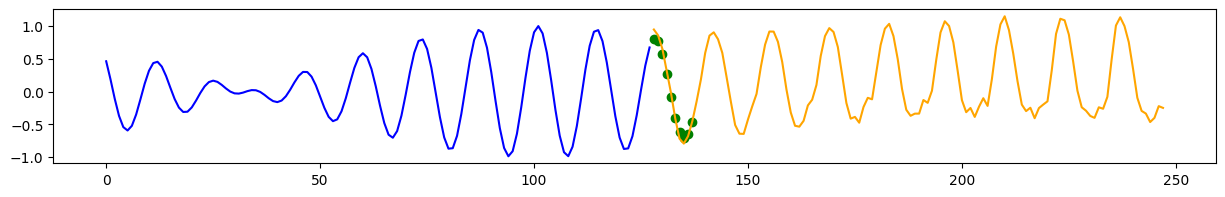

In [21]:
plt.figure(num=None, figsize=(15,2))  
plt.plot(range(0, seq_length),x_test[0,:,0],'b-')
plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')
plt.plot(range(seq_length, seq_length + 120),predrnn,color='orange')
plt.show()

## D) LSTM Cell
Repeat C) but now with an LSTM cell.

In [22]:
state_size = 12
modellstm = Sequential()
modellstm.add(LSTM(state_size, batch_input_shape=(None, None, 1), return_sequences=True))
modellstm.add(LSTM(state_size, return_sequences=True))
modellstm.add(LSTM(state_size, return_sequences=True))
modellstm.add(LSTM(state_size, return_sequences=True))
modellstm.add(Dense(1))
def slice(x, slice_length):
    return x[:,-slice_length:,:]
modellstm.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modellstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 12)          672       
                                                                 
 lstm_1 (LSTM)               (None, None, 12)          1200      
                                                                 
 lstm_2 (LSTM)               (None, None, 12)          1200      
                                                                 
 lstm_3 (LSTM)               (None, None, 12)          1200      
                                                                 
 dense_3 (Dense)             (None, None, 1)           13        
                                                                 
 lambda_3 (Lambda)           (None, None, 1)           0         
                                                                 
Total params: 4,285
Trainable params: 4,285
Non-traina

In [23]:
modellstm.compile(optimizer='adam', loss='mean_squared_error')
history = modellstm.fit(X[0:800], Y[0:800], epochs=20, batch_size=128, validation_data=(X[800:1000], Y[800:1000]))

Epoch 1/20
7/7 [==============================] - 13s 485ms/step - loss: 0.2802 - val_loss: 0.2749
Epoch 2/20
7/7 [==============================] - 1s 164ms/step - loss: 0.2756 - val_loss: 0.2741
Epoch 3/20
7/7 [==============================] - 1s 161ms/step - loss: 0.2740 - val_loss: 0.2710
Epoch 4/20
7/7 [==============================] - 2s 260ms/step - loss: 0.2713 - val_loss: 0.2674
Epoch 5/20
7/7 [==============================] - 2s 212ms/step - loss: 0.2669 - val_loss: 0.2614
Epoch 6/20
7/7 [==============================] - 1s 183ms/step - loss: 0.2589 - val_loss: 0.2496
Epoch 7/20
7/7 [==============================] - 1s 183ms/step - loss: 0.2436 - val_loss: 0.2261
Epoch 8/20
7/7 [==============================] - 1s 182ms/step - loss: 0.2123 - val_loss: 0.1792
Epoch 9/20
7/7 [==============================] - 1s 204ms/step - loss: 0.1551 - val_loss: 0.1162
Epoch 10/20
7/7 [==============================] - 1s 198ms/step - loss: 0.0960 - val_loss: 0.0706
Epoch 11/20
7/7 [=

In [24]:
predlstm = predict_sequence(modellstm, x_test, 12)

1/1 [==============================] - 0s 94ms/step


C:\Users\malte\AppData\Local\Temp\ipykernel_16092\652466220.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')


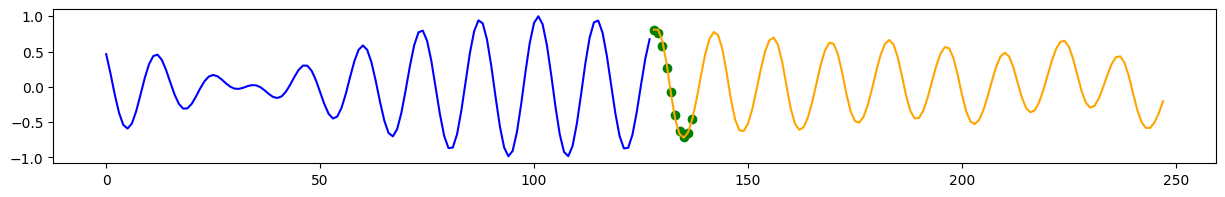

In [25]:
plt.figure(num=None, figsize=(15,2))  
plt.plot(range(0, seq_length),x_test[0,:,0],'b-')
plt.plot(range(seq_length, seq_length + look_ahead),y_test[0,:,0],'bo',color='green')
plt.plot(range(seq_length, seq_length + 120),predlstm,color='orange')
plt.show()